In [1]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
from torch.utils.data import Dataset, DataLoader
import torch
from flecs.utils import set_seed
from tqdm import tqdm
import numpy as np
import scvelo as scv
import matplotlib.pyplot as plt
import os
from flecs.utils import get_project_root
from flecs.sc.model import GRNCellPop, ProteinLevelPop
from flecs.trajectory import simulate_deterministic_trajectory
import anndata as ad
import seaborn as sns
from scvelo import tl
import pandas as pd

scv.set_figure_params('scvelo')  # for beautified visualization
plt.rcParams["figure.figsize"] = (8,4)

## Load data

In [2]:
set_seed(0)
adata = sc.read_h5ad(os.path.join(get_project_root(), "figure2", "processed", "adata_processed_with_paths_magic.h5ad")
                     )

In [3]:
len(adata)

7296

In [4]:
def get_cell_indices(adata):
    # Get the indices of cells for the different populations
    cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
    unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))
    cebpa_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpa KO'].index.astype("int"))
    cebpe_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Cebpe KO'].index.astype("int"))

    return cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells

In [5]:
# Get cell indices coming from the different batches
cmp_cells, unsorted_cells, cebpa_cells, cebpe_cells = get_cell_indices(adata)
cmp_unsorted_adata = adata[cmp_cells + unsorted_cells]

## Model

In [6]:
batch_size = cmp_unsorted_adata.shape[0] // 2
n_latent = 0

In [7]:
print(batch_size)

2112


In [8]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

## Load weights

In [9]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_jul_19_2.pt"
                                             ), 
                                map_location=torch.device('cpu'))

In [10]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

## Evaluate velocity confidence

### FleCS

In [22]:
plt.rcParams["figure.figsize"] = (4,2.5)

In [11]:
cmp_unsorted_adata.layers["Ms"] = cmp_unsorted_adata.layers["counts"]

In [12]:
sc.pp.neighbors(cmp_unsorted_adata)

In [13]:
with torch.no_grad():
    
    unsorted_velocities = []
        
    for i in tqdm(range(cmp_unsorted_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_unsorted_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(gene_expr)

        unsorted_velocities.append(velocity)
        
unsorted_velocities = torch.cat(unsorted_velocities).cpu().numpy()[:, :, 0]
cmp_unsorted_adata.layers["velocity"] = unsorted_velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

100%|██████████| 2/2 [00:37<00:00, 18.99s/it]


In [14]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:23) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [15]:
tl.velocity_confidence(cmp_unsorted_adata, vkey="velocity")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


In [16]:
results_flecs = pd.DataFrame(cmp_unsorted_adata.obs["velocity_confidence"])
results_flecs["method"] = "FLeCS"
results_flecs["dim_dynamics"] = 4000

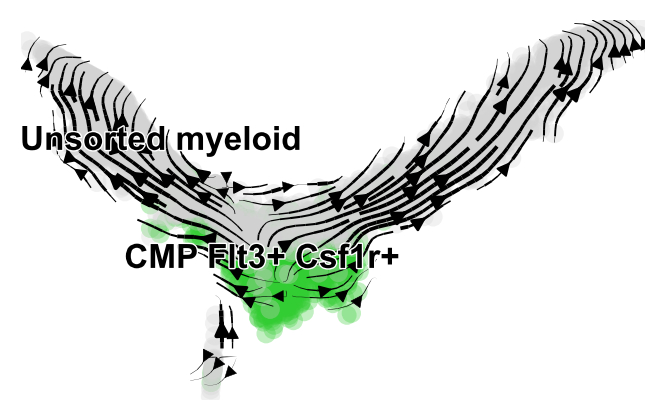

In [23]:
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs", vkey="velocity",  palette=["limegreen", "lightgrey"], title="")

### FLeCS with latent variables

In [24]:
n_latent = 50

In [25]:
mycellpop = GRNCellPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [26]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_jul_19_3.pt"
                                             ), 
                                map_location=torch.device('cpu'))

In [27]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [28]:
with torch.no_grad():
    
    unsorted_velocities = []
        
    for i in tqdm(range(cmp_unsorted_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_unsorted_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        velocity = mycellpop.get_derivatives(torch.cat((gene_expr, torch.zeros(batch_size, n_latent, 1)), dim=1))

        unsorted_velocities.append(velocity[:, :-n_latent])
        
unsorted_velocities = torch.cat(unsorted_velocities).cpu().numpy()[:, :, 0]
cmp_unsorted_adata.layers["velocity"] = unsorted_velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

100%|██████████| 2/2 [01:04<00:00, 32.03s/it]


In [29]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [30]:
tl.velocity_confidence(cmp_unsorted_adata, vkey="velocity")

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)


In [31]:
results_flecs_latent = pd.DataFrame(cmp_unsorted_adata.obs["velocity_confidence"])
results_flecs_latent["method"] = "FLeCS with latents"
results_flecs_latent["dim_dynamics"] = 4000

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


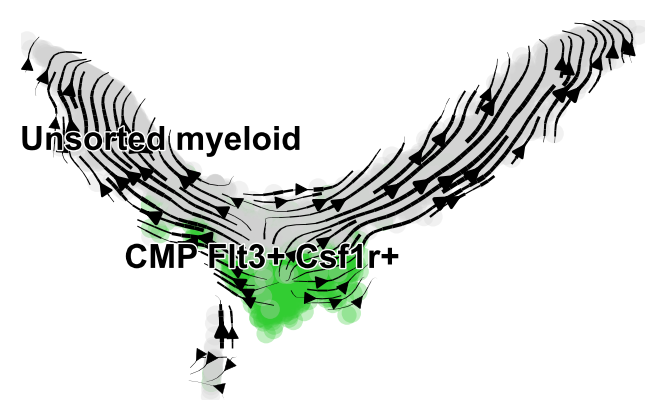

In [32]:
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs", vkey="velocity", palette=["limegreen", "lightgrey"], title="")

### FLeCS with protein proxy variables

In [33]:
n_latent = 0

In [34]:
mycellpop = ProteinLevelPop(adata=adata, batch_size=batch_size, n_latent_var=n_latent, use_2nd_order_interactions=False)

In [35]:
# Load trained weights
trained_state_dict = torch.load(os.path.join(get_project_root(), "figure2", "logs", 
                                             "trained_mycellpop_24_jul_19_4.pt"
                                             ), 
                                map_location=torch.device('cpu'))

In [36]:
mycellpop["gene"].alpha.data = trained_state_dict["alpha"]
mycellpop["gene"].bias.data = trained_state_dict["bias"]
mycellpop["gene", "regulates", "gene"].simple_conv_weights.data = trained_state_dict["simple_conv_weights"]

In [37]:
with torch.no_grad():
    
    unsorted_velocities = []
        
    for i in tqdm(range(cmp_unsorted_adata.shape[0] // batch_size)):
        gene_expr = torch.Tensor(cmp_unsorted_adata.X[i*batch_size: (i + 1)*batch_size, :, None])
        gene_expr = torch.cat((gene_expr, gene_expr), dim=2)
        velocity = mycellpop.get_derivatives(gene_expr)

        unsorted_velocities.append(velocity)
        
unsorted_velocities = torch.cat(unsorted_velocities).cpu().numpy()[:, :, 0]
cmp_unsorted_adata.layers["velocity"] = unsorted_velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

100%|██████████| 2/2 [00:28<00:00, 14.32s/it]


In [38]:
scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [69]:
results_flecs_protein = pd.DataFrame(cmp_unsorted_adata.obs["velocity_confidence"])
results_flecs_protein["method"] = "FLeCS with \nprotein proxies"
results_flecs_protein["dim_dynamics"] = 4000

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


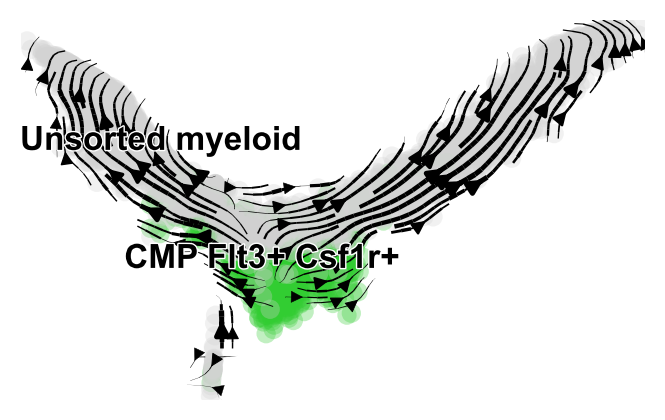

In [40]:
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, basis='umap', color="Batch_desc", layer="obs", vkey="velocity", palette=["limegreen", "lightgrey"], title="")

### ScTour

In [41]:
def get_sctour_velo(file_name, n_latent):
    # Retrieve sctour velocities and compute their confidence
    sctour_adata = sc.read(os.path.join(get_project_root(), "figure2", "processed", file_name))
    sctour_adata.layers["Ms"] = sctour_adata.layers["counts"]  # sctour_adata.X 

    sc.pp.neighbors(sctour_adata)

    # Trick to be able to us scvelo methods
    sctour_adata = sctour_adata[:, :n_latent].copy()
    sctour_adata.layers["X_VF"] = sctour_adata.obsm["X_VF"]

    tl.velocity_graph(sctour_adata, vkey="X_VF", n_jobs=8)
    tl.velocity_confidence(sctour_adata, vkey="X_VF")

    results_sctour = pd.DataFrame(sctour_adata.obs["X_VF_confidence"])
    results_sctour["method"] = "sctour"
    results_sctour["dim_dynamics"] = n_latent

    if n_latent == 4000:
        scv.pl.velocity_embedding_stream(sctour_adata, basis='umap', color="Batch_desc", layer="obs", vkey="X_VF", palette=["limegreen", "lightgrey"], title="")

    return results_sctour

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'X_VF_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'X_VF_length' (adata.obs)
--> added 'X_VF_confidence' (adata.obs)
--> added 'X_VF_confidence_transition' (adata.obs)
computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'X_VF_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'X_VF_length' (adata.obs)
--> added 'X_VF_confidence' (adata.obs)
--> added 'X_VF_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'X_VF_umap', embedded velocity vectors (adata.obsm)


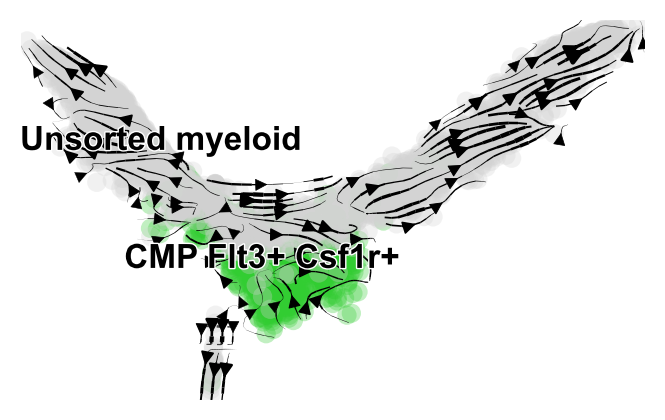

In [42]:
all_results_sctour = []

for file_name, n_latent in zip(["adata_sctour_velo_10.h5ad", "adata_sctour_velo_4000.h5ad"], [10, 4000]):
    all_results_sctour.append(get_sctour_velo(file_name, n_latent))

In [43]:
results_sctour = pd.concat(all_results_sctour)

### Baseline based on extracted trajectories

In [46]:
def get_baseline_velocity_confidence(_adata):
    
    _adata = _adata.copy()

    _adata.layers["velocity"] = np.zeros(_adata.shape)
    _adata.layers["Ms"] = _adata.layers["counts"]  # _adata.X
    _adata.layers["X"] = _adata.X

    for v in _adata.uns["unsorted_shortest_paths"].values():
        for i in range(len(v) - 1):
            _adata.layers["velocity"][v[i]] = _adata.X[v[i+1]] - _adata.X[v[i]]

    # Only consider cells that belong to a path to compute statistics
    nonzero_velo_adata = _adata[np.any(_adata.layers["velocity"], axis=1)]
    
    sc.pp.neighbors(nonzero_velo_adata)
    tl.velocity_graph(nonzero_velo_adata, xkey="X", n_jobs=8)
    tl.velocity_confidence(nonzero_velo_adata, vkey="velocity")

    _results = pd.DataFrame(nonzero_velo_adata.obs["velocity_confidence"])
    _results["method"] = "Extracted Trajectory \n Baseline"
    _results["dim_dynamics"] = 4000

    scv.pl.velocity_embedding_stream(nonzero_velo_adata, basis='umap', color="Batch_desc", layer="obs", vkey="velocity", palette=["limegreen", "lightgrey"], title="")

    return _results

computing velocity graph (using 8/8 cores)


  0%|          | 0/1935 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


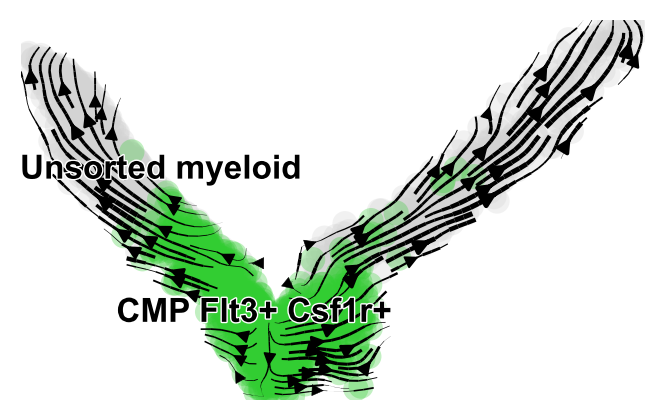

In [47]:
results_baseline = get_baseline_velocity_confidence(adata)

## OT-CFM

In [48]:
otcfm_adata = sc.read(os.path.join(get_project_root(), "figure2", "processed", "adata_ot_cfm.h5ad"))
otcfm_adata.layers["Ms"] = otcfm_adata.layers["counts"]

sc.pp.neighbors(otcfm_adata)

otcfm_adata.layers["OT_CFM_velocity"] = otcfm_adata.obsm["OT_CFM_velocity"]

tl.velocity_graph(otcfm_adata, vkey="OT_CFM_velocity", n_jobs=8)
tl.velocity_confidence(otcfm_adata, vkey="OT_CFM_velocity")

results_otcfm = pd.DataFrame(otcfm_adata.obs["OT_CFM_velocity_confidence"])
results_otcfm["method"] = "OT-CFM"
results_otcfm["dim_dynamics"] = 4000

computing velocity graph (using 8/8 cores)


  0%|          | 0/4224 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'OT_CFM_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'OT_CFM_velocity_length' (adata.obs)
--> added 'OT_CFM_velocity_confidence' (adata.obs)
--> added 'OT_CFM_velocity_confidence_transition' (adata.obs)


computing velocity embedding
    finished (0:00:00) --> added
    'OT_CFM_velocity_umap', embedded velocity vectors (adata.obsm)


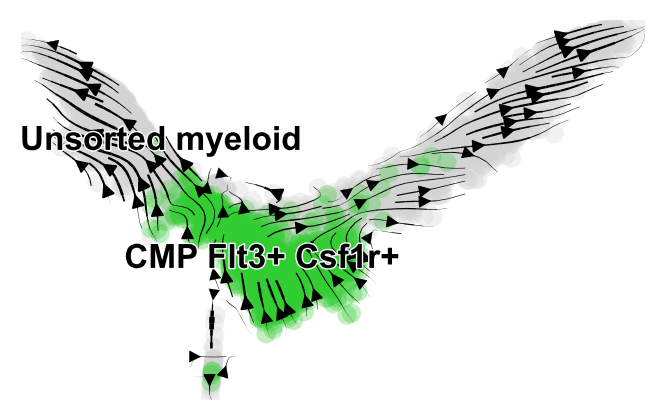

In [49]:
scv.pl.velocity_embedding_stream(otcfm_adata, basis='umap', color="Batch_desc", layer="obs", vkey="OT_CFM_velocity",  palette=["limegreen", "lightgrey"], title="")

## Plot

In [70]:
results_df = pd.DataFrame(np.concatenate((results_flecs, results_flecs_latent, results_flecs_protein, results_sctour, results_otcfm, results_baseline), axis=0))
results_df.columns = ["velocity confidence", "method", "dim_dynamics"]

results_df["velocity confidence"] = results_df["velocity confidence"].astype(float)

In [71]:
results_df

,velocity confidence,method,dim_dynamics
0,0.994094,FLeCS,4000
1,0.994716,FLeCS,4000
2,0.990813,FLeCS,4000
3,0.994923,FLeCS,4000
4,0.977133,FLeCS,4000
...,...,...,...
27274,0.408799,Extracted Trajectory \n Baseline,4000
27275,0.353575,Extracted Trajectory \n Baseline,4000
27276,0.462300,Extracted Trajectory \n Baseline,4000
27277,0.524515,Extracted Trajectory \n Baseline,4000


In [72]:
results_df["Method name"] = results_df.apply(lambda x: "scTour (dim " + str(x["dim_dynamics"]) + ")" 
                                             if x["method"] == "sctour" else x["method"], axis=1)

In [73]:
results_df["log(1 - velocity confidence)"] = results_df["velocity confidence"].apply(lambda x: np.log(1 - x))

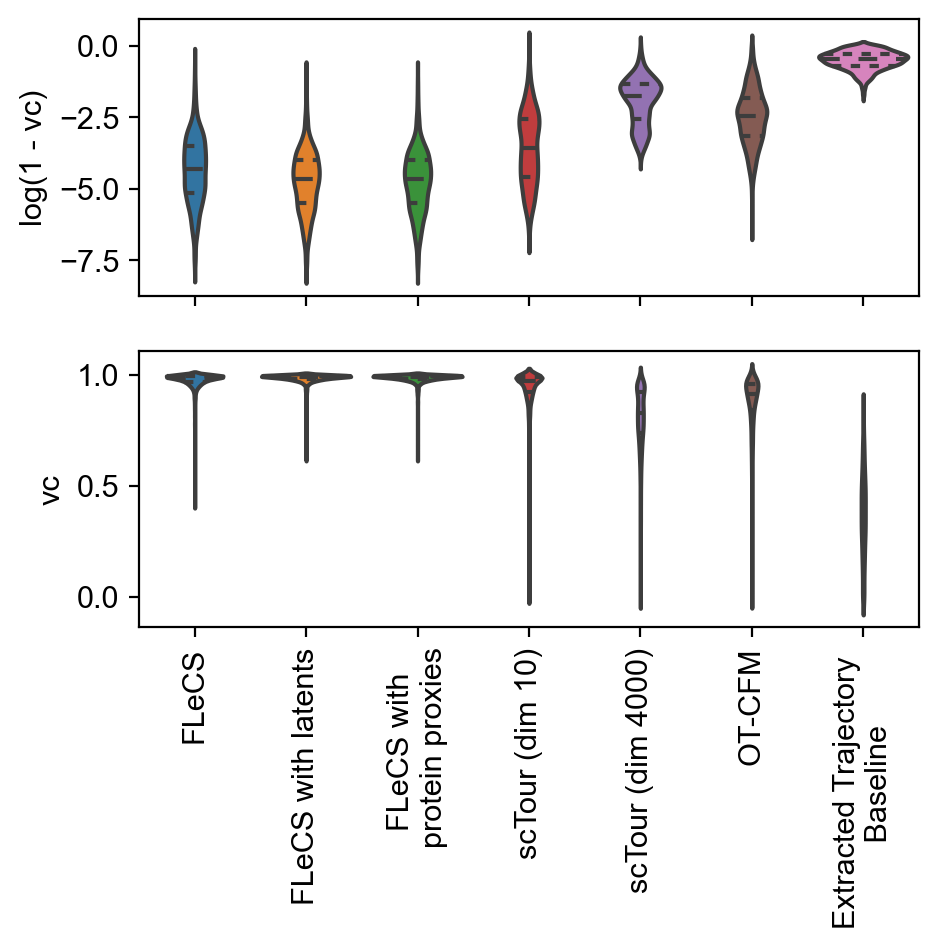

In [75]:
plt.rcParams["figure.figsize"] = (5, 4)
f, axes = plt.subplots(2, 1, sharex=True)
sns.violinplot(results_df, y="log(1 - velocity confidence)", x="Method name", inner="quart", ax=axes[0])
axes[0].set_ylabel("log(1 - vc)")
axes[0].set_xlabel("")

sns.violinplot(results_df, y="velocity confidence", x="Method name", inner="quart", ax=axes[1])
axes[1].set_ylabel("vc")
axes[1].set_xlabel("")

plt.xticks(rotation=90)
plt.show()